# Regression Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 6
### David Lowe
### April 9, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: [Sample Paragraph - The purpose of the analysis is to predict the housing values in the suburbs of Boston by using the home sale transaction history.]

ANALYSIS: [Sample Paragraph - The baseline performance of the model achieved a root mean squared error (RMSE) of 6.9113. After tuning the hyperparameters, the best model processed the training dataset with an RMSE of 3.4193. Furthermore, the final model processed the test dataset with an RMSE of 3.2451, which was consistent with the training result.]

CONCLUSION: For this dataset, the model built using TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Regression with numerical attributes

Dataset Reference: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.data]

One potential source of performance benchmarks: [https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/]

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
# Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [2]:
# Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [3]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [4]:
# Set the random seed number for reproducible results
seedNum = 888

In [5]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import pandas as pd
import math
import os
import sys
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [6]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.he_uniform(seed=seedNum)
default_epoch = 50
default_batch = 32

Num GPUs Available:  0


In [7]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [8]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [9]:
if (notifyStatus): email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [10]:
if (notifyStatus): email_notify("Task 2. Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [11]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
colNames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
Xy_original = pd.read_csv(dataset_path, names=colNames, delim_whitespace=True, header=None)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [12]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [13]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['attribute_name'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['attribute_name'].fillna(value=Xy_original['attribute_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with Y/N levels into categorical feature of 1/0
# def reClassSomecol(target):
#     if (target == 'Y'): return 1
#     else: return 0
# Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
# Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [17]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [18]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [19]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [20]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (506, 14) X_original.shape: (506, 13) y_original.shape: (506,)


In [21]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

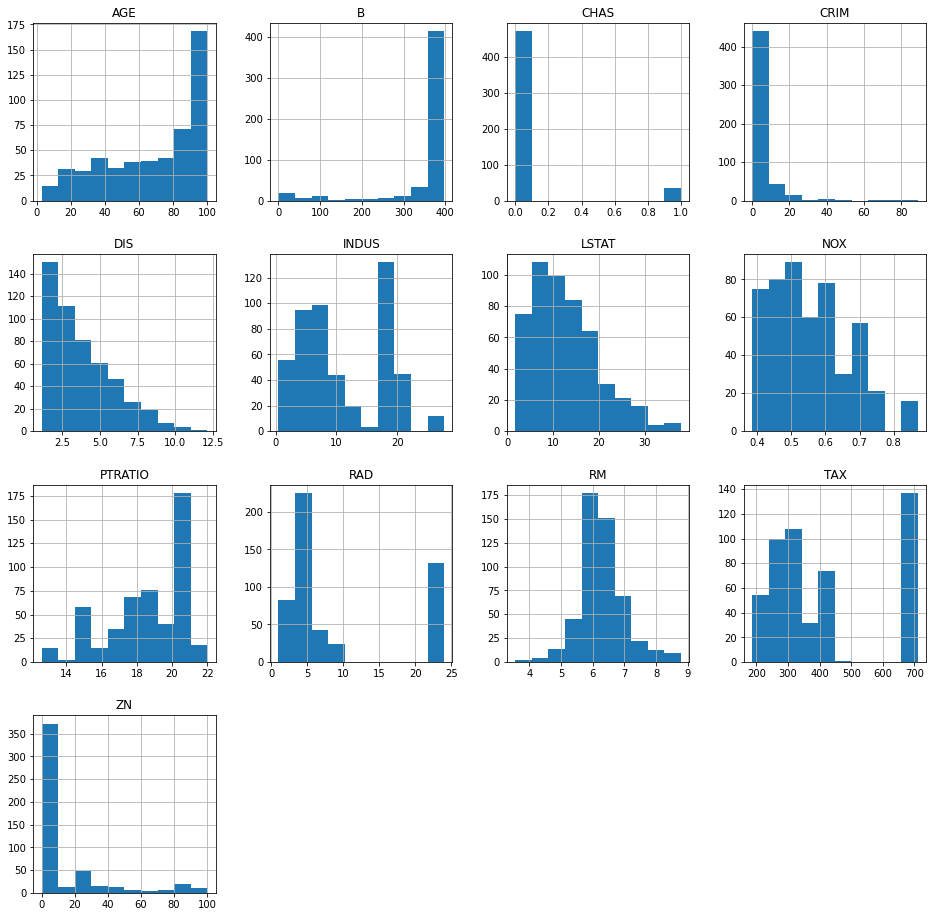

In [22]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [23]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [24]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,-0.408212,-0.487722,2.422565,-0.272599,0.469104,-0.429726,1.074822,-0.916009,-0.637962,1.798194,0.760340,0.366604,0.759313
492,-0.407563,-0.487722,2.422565,-0.272599,0.469104,-0.429726,0.530745,-0.801065,-0.637962,1.798194,0.760340,0.441052,0.097692
493,-0.400349,-0.487722,-0.211099,-0.272599,0.261784,-0.822932,-0.518292,-0.671859,-0.408041,-0.102376,0.344213,0.441052,-0.090141
494,-0.387983,-0.487722,-0.211099,-0.272599,0.261784,-0.510932,-0.923682,-0.671859,-0.408041,-0.102376,0.344213,0.441052,0.131334


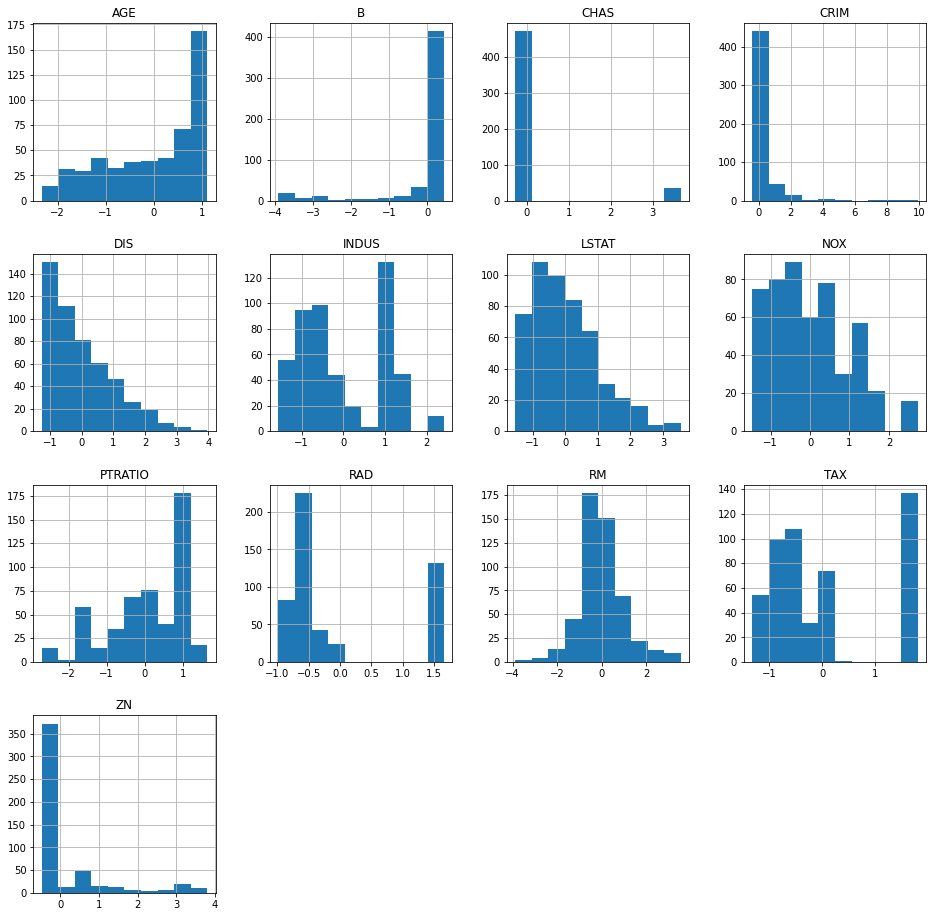

In [25]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [26]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [27]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (379, 13) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (379,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (127, 13) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (127,) y_test.type: <class 'numpy.ndarray'>


In [28]:
if (notifyStatus): email_notify("Task 1. Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 3. Define and Train Model

In [29]:
if (notifyStatus): email_notify("Task 3. Define and Fit Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [30]:
# Define the baseline model for benchmarking
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(25, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [31]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model = create_default_model()
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch,
                                   validation_data=(X_test, y_test), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Train on 379 samples, validate on 127 samples
Epoch 1/50
379/379 [==============================] - 1s 2ms/sample - loss: 676.9069 - val_loss: 686.3243
Epoch 2/50
379/379 [==============================] - 0s 127us/sample - loss: 658.7726 - val_loss: 667.6340
Epoch 3/50
379/379 [==============================] - 0s 129us/sample - loss: 641.5426 - val_loss: 649.5173
Epoch 4/50
379/379 [==============================] - 0s 129us/sample - loss: 624.9274 - val_loss: 632.3510
Epoch 5/50
379/379 [==============================] - 0s 123us/sample - loss: 609.0734 - val_loss: 615.4614
Epoch 6/50
379/379 [==============================] - 0s 130us/sample - loss: 593.3868 - val_loss: 598.8410
Epoch 7/50
379/379 [==============================] - 0s 136us/sample - loss: 578.0192 - val_loss: 582.5808
Epoch 8/50
379/379 [==============================] - 0s 124us/sample - loss: 562.6578 - val_loss: 566.3544
Epoch 9/50
379/379 [==============================] - 0s 135us/sample - loss: 547.4785 - val

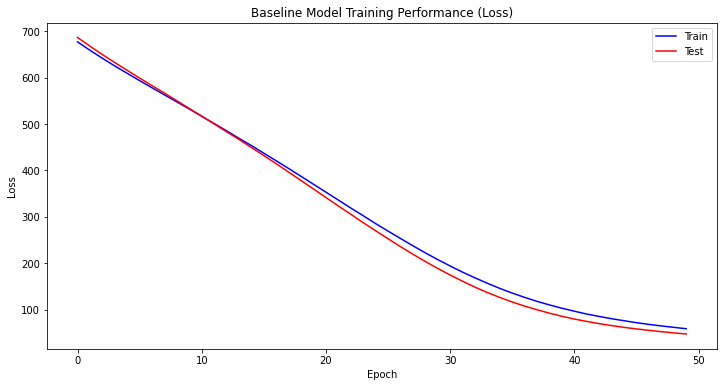

In [32]:
# Summarize model training hisotry
fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [33]:
if (notifyStatus): email_notify("Task 3. Define and Fit Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [34]:
if (notifyStatus): email_notify("Task 4. Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(25, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer)
    return customized_model

In [36]:
startTimeModule = datetime.now()

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optz_2 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optz_3 = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.keras.initializers.he_uniform(seed=seedNum)
init_2 = tf.keras.initializers.Orthogonal(seed=seedNum)
init_3 = tf.keras.initializers.RandomUniform(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #3 has the object ID of', init_3)

epoch_grid = [default_epoch]
batch_grid = [int(default_batch/2), default_batch, int(default_batch*2)]

best_score = float('inf')
grid_iteration = 0
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for epoch_num in epoch_grid:
            for batch_num in batch_grid:
                print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
                      % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
                reset_random(seedNum)
                grid_model = create_customized_model(optimizer, kernel_init)
                grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, 
                                       validation_data=(X_test, y_test), verbose=1)
                if(grid_hist.history['val_loss'][-1] < best_score):
                    best_score = grid_hist.history['val_loss'][-1]
                    best_iteration = grid_iteration
                    best_optimizer = optimizer
                    best_kernel_init = kernel_init
                    best_epoch = epoch_num
                    best_batch = batch_num
                grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (lowest validation loss) found via grid search: loss=%f RMSE=%f from model iteration #%d"
      % (best_score, math.sqrt(best_score), best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f6c08f41350>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f6c08f41390>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f6c08f413d0>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f6c08f84bd0>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f6c08f415d0>
Initializer candidate #3 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomUniform object at 0x7f6c08f41550>

Forming the grid-search model #0 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f6c08f41350>, kernel=<tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f6c08f84bd0>, epochs=50, batch_size=16
Train on 379 samples, validate 

In [37]:
best_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
best_kernel_init = tf.keras.initializers.he_uniform(seed=seedNum)
best_epoch = 25
best_batch = 16

In [38]:
if (notifyStatus): email_notify("Task 4. Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [39]:
if (notifyStatus): email_notify("Task 5. Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
reset_random(seedNum)
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_hist = final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, validation_data=(X_test, y_test), verbose=1)

Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f6c183cf210>, kernel=<tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f6c183cf250>, epochs=25, batch_size=16
Train on 379 samples, validate on 127 samples
Epoch 1/25
379/379 [==============================] - 1s 2ms/sample - loss: 101.9401 - val_loss: 19.7664
Epoch 2/25
379/379 [==============================] - 0s 209us/sample - loss: 23.9916 - val_loss: 11.9112
Epoch 3/25
379/379 [==============================] - 0s 208us/sample - loss: 18.6678 - val_loss: 11.6341
Epoch 4/25
379/379 [==============================] - 0s 219us/sample - loss: 15.9325 - val_loss: 12.6047
Epoch 5/25
379/379 [==============================] - 0s 205us/sample - loss: 14.4156 - val_loss: 10.1476
Epoch 6/25
379/379 [==============================] - 0s 214us/sample - loss: 14.5387 - val_loss: 15.5928
Epoch 7/25
379/379 [==============================] - 0s 225us/sample - loss: 18.0

In [41]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 25)                350       
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 26        
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_28', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_56', 'trainable': True, 'batch_input_shape': (None, 13), 'dtype': 'float32', 'units': 25, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_57', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_const

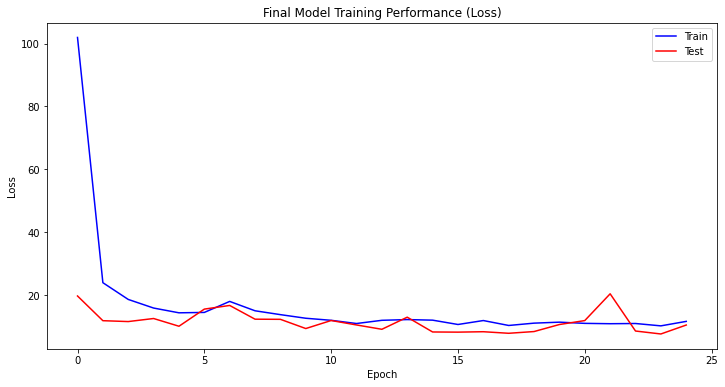

In [44]:
# Summarize model training hisotry
fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.subplot(111)
plt.plot(final_hist.history['loss'], color='blue', label='train')
plt.plot(final_hist.history['val_loss'], color='red', label='test')
plt.title('Final Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [45]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("Final MSE of the model: %f" % (scores))
print("Final RMSE of the model: %f" % (math.sqrt(scores)))

127/127 [==============================] - 0s 89us/sample - loss: 10.5313
Final MSE of the model: 10.531313
Final RMSE of the model: 3.245199


In [46]:
# Make class predictions with the model
predictions = final_model.predict(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %.2f (expected %.2f)' % (i, predictions[i], y_test[i]))

Data item #0 predicted to be 20.77 (expected 22.40)
Data item #1 predicted to be 32.14 (expected 32.40)
Data item #2 predicted to be 18.85 (expected 21.70)
Data item #3 predicted to be 19.55 (expected 24.50)
Data item #4 predicted to be 22.76 (expected 16.80)
Data item #5 predicted to be 20.56 (expected 21.10)
Data item #6 predicted to be 29.24 (expected 29.40)
Data item #7 predicted to be 24.86 (expected 28.70)
Data item #8 predicted to be 20.62 (expected 21.50)
Data item #9 predicted to be 13.55 (expected 13.60)
Data item #10 predicted to be 20.71 (expected 21.40)
Data item #11 predicted to be 21.59 (expected 24.80)
Data item #12 predicted to be 16.19 (expected 16.80)
Data item #13 predicted to be 18.10 (expected 19.40)
Data item #14 predicted to be 19.85 (expected 21.70)
Data item #15 predicted to be 12.90 (expected 17.20)
Data item #16 predicted to be 12.90 (expected 17.10)
Data item #17 predicted to be 18.89 (expected 18.70)
Data item #18 predicted to be 19.84 (expected 22.30)
Dat

In [47]:
if (notifyStatus): email_notify("Task 5. Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:42.878484
